In [1]:
import random

import torch
import numpy as np
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, RSTDP_INH_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4, LateralInhibition
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d, BackwardConnections
from libs.network import MultiConnectionNetwork

In [2]:
seed = random.randint(0,9999999)
print(seed)

8271348


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Prepare Inputs

In [4]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 5000
categories = 2
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time)

session_class = torch.randint(0, categories, (session_number, ))
active_fire_rate = 0.13

def fill_spiketrain_from_classes_vector(session_class, spike_train):
    pattern_size = int(input_size_c1/categories)
    for idx, cls in enumerate(session_class):
        passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
        spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise

        pattern = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern[each_session - gap_time:, :] = 0

        spike_train[idx * each_session: (idx + 1) * each_session, pattern_size*cls:pattern_size*(cls + 1)] |= pattern
        timestep_class[idx * each_session: (idx + 1) * each_session] = cls
        
fill_spiketrain_from_classes_vector(session_class, spike_train_c1)
fill_spiketrain_from_classes_vector(session_class, spike_train_c2)

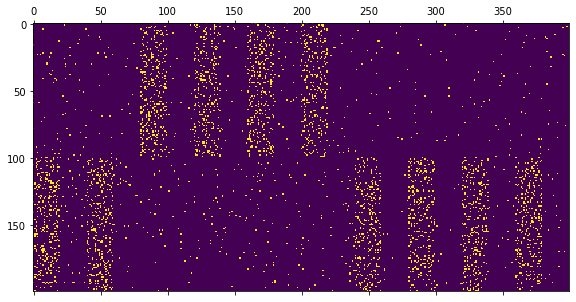

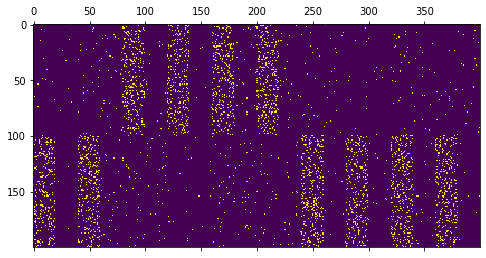

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train_c1.T[:, :10 * each_session])
plt.matshow(spike_train_c2.T[:, :10 * each_session])

# Configs

In [6]:
def noise_val():
    start_noise = 2
    return (start_noise - start_noise * part / session_number) + 2.5

def net_noise_val():
    return -noise_val()

In [7]:
lr_coef = 10.0
thresh_noise = 3
soft_bound = True

connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 2,
    'weight': 12,
}
layer_args_l23 = {
    'pop_size': get_output_size_maxpool1d(100, 5, 2),
    'inh_con_args': { # Inside Layer
        'wmin': -1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 2.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.0,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'noise': (0, 0),
        'thresh_noise': thresh_noise,
    }
}
layer_args_l4 = { 
    'pop_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.0,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'noise': (net_noise_val, noise_val),
        'thresh_noise': thresh_noise,
    }
}
cc_to_c3_con_args = {
    'wmin': 0.,
    'wmax': 0.7,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
    'probability': 0.30,
    
    'update_rule': MSTDPET_SEASONAL,
    'soft_bound': soft_bound,
    'normal_distr': 0.1,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
backward_args_kw = {
    'backward': False,
    'backward_exc_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_SEASONAL,
        'soft_bound': soft_bound,
        'normal_distr': 0.2,
        'direct_voltage_manipulation': True,
        'wmin': 0.,
        'wmax': 0.95,
        'nu': [0.003, 0.007],
        'enable': True,

        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    },
    'backward_inh_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_INH_SEASONAL,
        'soft_bound': soft_bound,
        'normal_distr': 0.2,
        'direct_voltage_manipulation': True,
        'wmin': -0.95,
        'wmax': 0,
        'nu': [0.007, 0.003],
        'enable': True,
        'behavior': 'inh',

        'windows_size': 5,
        'windows_std': 0.5,
        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    }
}

input_2_cc = {
    'wmin': 0.,
    'wmax': 0.7,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
    'probability': 0.50,
    
    'update_rule': MSTDPET_SEASONAL,
    'soft_bound': soft_bound,
    'normal_distr': 0.1,
    'tc_plus': 6,
    'tc_minus': 6, 
    'tc_e_trace': 6,
}

connection_type = RandomConnection

In [8]:
# Categories
connection_args_categories = { # Between Layer
    'kernel_size': 5,
    'stride': 2,
    'weight': 8,
}
l4_pop_size_cat = 50
layer_args_l23_categories = {
    'pop_size': get_output_size_maxpool1d(l4_pop_size_cat, 5, 2),
    'inh_con_args': { # Inside Layer
        'wmin': -1,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.0,
    },
    'pop_args': {
        'thresh': -51.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 1,
        'noise': (0, 0),
        'thresh_noise': thresh_noise,
    }
}
layer_args_l4_categories = {
    'pop_size': l4_pop_size_cat,
    'inh_con_args': { # Inside Layer
        'wmin': -1,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.50,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.0,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 1,
        'noise': (net_noise_val, noise_val),
        'thresh_noise': thresh_noise,
    }
}
c3_to_category_cc_con_args = {
    'wmin': 0.,
    'wmax': 0.6,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
    'probability': 0.8,
    
    'update_rule': MSTDPET_SEASONAL,
    'soft_bound': soft_bound,
    'normal_distr': 0.1,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
cats_lateral_connection_args = {
    'wmin': -1.0,
    'wmax': 0,
    'update_rule': NoOp,
    'probability': 0.50,
}

# Create Network

In [9]:
model = ComplexStructure()

In [10]:
# CC1 and input
input_pop_c1 = Input(input_size_c1, traces=True, tc_trace=6)
input_name_c1 = f'input_c1'
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c1", monitor=LAYER_23|LAYER_4, **backward_args_kw)
input_to_c1_connection = LayerConnection((input_name_c1, input_pop_c1), c1, connection_type, input_2_cc)
model.add_submodule(c1)
model.add_submodule(input_to_c1_connection)
model.add_pop(input_name_c1, input_pop_c1)

# CC2 and input
input_pop_c2 = Input(input_size_c2, traces=True, tc_trace=6)
input_name_c2 = f'input_c2'
c2 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c2", monitor=LAYER_23|LAYER_4, **backward_args_kw)
input_to_c2_connection = LayerConnection((input_name_c2, input_pop_c2), c2, connection_type, input_2_cc)
model.add_submodule(c2)
model.add_submodule(input_to_c2_connection)
model.add_pop(input_name_c2, input_pop_c2)

In [11]:
# CC3 and connections to
c3 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c3", monitor=LAYER_23|LAYER_4, **backward_args_kw)
c1_c3_connection = LayerConnection(c1, c3, connection_type, cc_to_c3_con_args)
c2_c3_connection = LayerConnection(c2, c3, connection_type, cc_to_c3_con_args)
model.add_submodule(c3)
model.add_submodule(c1_c3_connection)
model.add_submodule(c2_c3_connection)

In [12]:
categories_cc_list = []
c3_to_cat_connections = []

for i in range(categories):
    cc_name = f"c_cat_{i}"
    c_cat = CorticalColumn(connection_args_categories, layer_args_l23_categories, layer_args_l4_categories, name=cc_name, monitor=LAYER_23|LAYER_4, **backward_args_kw)
    c3_cat_connection = LayerConnection(c3, c_cat, connection_type, c3_to_category_cc_con_args)
    c3_to_cat_connections += c3_cat_connection.connections
    categories_cc_list.append((cc_name, c3_cat_connection, c_cat, ))
    model.add_submodule(c_cat)
    model.add_submodule(c3_cat_connection)
    
cats_lateral_connection = LateralInhibition(
    ccs=[cc_tuple[2] for cc_tuple in categories_cc_list],
    connection_args=cats_lateral_connection_args,
    connection_type=connection_type
)
model.add_submodule(cats_lateral_connection)

In [13]:
network = MultiConnectionNetwork(dt=1.0)
model.add_to_network(network)

In [14]:
bl_monitors = []
bl_monitors_name = []
for a, b, con in c3_to_cat_connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [15]:
# bl_monitors = []
# bl_monitors_name = []
# for a, b, con in c1_c3_connection.connections + c2_c3_connection.connections:
#     tmp = Monitor(obj=con, state_vars=['converge'])
#     network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
#     bl_monitors.append(tmp)
#     bl_monitors_name.append((a, b))
    

# Run Network


In [16]:
def get_all_backward_trigger_connections():
    cotrical_columns_list = [c1, c2, c3] + [cc for _, _, cc in categories_cc_list]
    cons = []
    for cc in cotrical_columns_list:
        if cc.backward_exc_connection:
            cons += cc.backward_exc_connection.get_connections()
        if cc.backward_inh_connection:
            cons += cc.backward_inh_connection.get_connections()
    return cons

def get_all_forward_trigger_connections():
    cat_cons = []
    for _, con, _ in categories_cc_list:
        cat_cons += con.get_connections()
    return (
        cat_cons +
        input_to_c1_connection.get_connections() +
        input_to_c2_connection.get_connections() +
        c1_c3_connection.get_connections() +
        c2_c3_connection.get_connections()
    )

def get_all_trigger_connections():
    return get_all_backward_trigger_connections() + get_all_forward_trigger_connections()

In [17]:
get_all_forward_trigger_connections()

[('c3_l23__pop',
  'c_cat_0_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('c3_l23__pop',
  'c_cat_1_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('input_c1',
  'c1_l4__pop',
  RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )),
 ('input_c2',
  'c2_l4__pop',
  RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )),
 ('c1_l23__pop',
  'c3_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('c2_l23__pop',
  'c3_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ))]

In [18]:
from tqdm import trange

rewards = []
reward_window = 10
winner = []
changes = []
# activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c3.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c3.l23.enable_learning()
#         c3.l4_l23.enable_learning()
    
    
    inp = {
        input_name_c1: spike_train_c1[part*each_session:part*each_session+each_session, :],
        input_name_c2: spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)
    
#     avg_sessions = 10
#     in_use_sessions = min(part + 1, avg_sessions)
#     exc1_avg = c3.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
#     exc2_avg = c3.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions

    activities = []
    for name, con, cc in categories_cc_list:
        activity = cc.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()
        activities.append((name, activity))
    # Find Maxinum Active Pop.
    max_index, max_value = -1, -1
    for idx, activity_pack in enumerate(activities):
        _, activity = activity_pack
        if activity > max_value:
            max_value = activity
            max_index = idx
    # Find Second Maxinum Active Pop.  
    sec_max_index, sec_max_value = -1, -1
    for idx, activity_pack in enumerate(activities):
        _, activity = activity_pack
        if idx == max_index:
            continue
        if activity > sec_max_value:
            sec_max_value = activity
            sec_max_index = idx
    
#     exc1_act = c3.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
#     exc2_act = c3.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
#     activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]  # Pattern Index
#     gap = abs(max_value - sec_max_value) / layer_args_l23_categories['pop_size'] # categories_l23_pop_size  #  In Range 0-1
#     gap_check = gap > 0.2
#     max_pos_activity = (layer_args_l23_categories['pop_size'] * each_session)
#     gap = abs(max_value - sec_max_value) / max_pos_activity
    
    gap = abs(max_value - sec_max_value) / (max_value + sec_max_value)
    if gap < 0.1:
        gap = 0
    gap *= 5
#     exc1_wins = exc1_act > exc2_act
    
#     if pattern == exc1_wins and gap_check:
#         reward = 1.0 + gap
#     elif pattern == exc1_wins:
#         reward = -0.5 + gap
#     else:
#         reward = -1 - gap

#     if gap_check:
#         reward = 0
    winnders_num = sum(winner[-reward_window:])
    pos_coef = 1 - winnders_num / reward_window
    neg_coef = winnders_num / reward_window

    
    if max_index == pattern: # and gap_check:
        reward = min(gap * pos_coef, 7)
    else:
        reward = max(-gap * neg_coef, -7)
        
    rewards.append(reward)
    winner.append(max_index == pattern)
    
    for conn in get_all_trigger_connections():
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [41:31<00:00,  2.01parts/s]


In [19]:
rewards

[0.0,
 tensor(0.),
 tensor(-0.),
 tensor(-0.),
 tensor(0.5102),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(-0.1200),
 tensor(-0.1429),
 tensor(0.),
 tensor(-0.1818),
 tensor(0.9600),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.7059),
 tensor(0.),
 tensor(0.),
 tensor(0.4000),
 tensor(0.),
 tensor(-0.3636),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.2500),
 tensor(0.5455),
 tensor(0.),
 tensor(0.),
 tensor(-0.7000),
 tensor(0.2128),
 tensor(-0.3462),
 tensor(0.),
 tensor(0.3462),
 tensor(0.1780),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.3750),
 tensor(0.),
 tensor(0.),
 tensor(-0.4906),
 tensor(0.),
 tensor(-0.4800),
 tensor(0.7059),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(-0.2500),
 tensor(-0.2234),
 tensor(-0.3158),
 tensor(0.),
 tensor(-0.3860),
 tensor(0.4800),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(-0.4889),
 tensor(0.),
 tensor(-0.3409),
 tensor(-0.2778),
 tensor(-0.3830),
 tensor(0.3061),
 tensor(0.),
 tensor(-0.1744

### Convergence

('c3_l23__pop', 'c_cat_0_l4__pop')
('c3_l23__pop', 'c_cat_1_l4__pop')


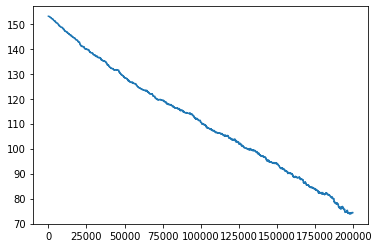

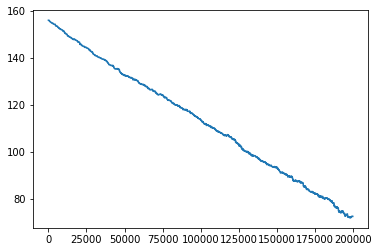

In [20]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [21]:
s = 0
for i in range(int(38000 / 40)-50, int(38000 / 40)+50):
#     print(rewards[i])
    s += rewards[i]
print(s)

tensor(2.6039)


### Rewards Moving Summation

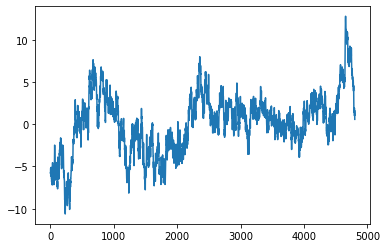

In [34]:
reward_summation = np.convolve(rewards, np.ones(200), 'valid')
plt.plot(reward_summation)

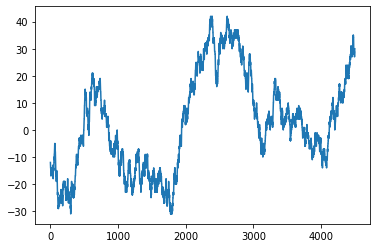

In [36]:
pos = np.convolve(torch.tensor(rewards) > 0, np.ones(500), 'valid')
neg = np.convolve(torch.tensor(rewards) < 0, np.ones(500), 'valid')
reward_summation = pos - neg
plt.plot(reward_summation)

# Visualization

In [24]:
time_show = time

spikes = {
    "C1 | L4": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C1 | L23": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    
    "C2 | L4": c2.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C2 | L23": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T,
    
    "C3 | L4": c3.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C3 | L23": c3.l23.monitors[0][1].get('s')[-time_show:,0,:].T,
}

for name, _, cc in categories_cc_list:
    spikes[f"{name} | L4"] = cc.l4.monitors[0][1].get('s')[-time_show:,0,:].T
    spikes[f"{name} | L23"] = cc.l23.monitors[0][1].get('s')[-time_show:,0,:].T
spikes

{'C1 | L4': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 'C1 | L23': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,  True, False],
         [False, False, False,  ..., False,  True, False],
         [False, False, False,  ..., False,  True, False]]),
 'C2 | L4': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...

In [25]:
def show_spikes(time, spikes_name, fig_size=(10,14)):
    nos = len(spikes_name)
    x = time
    fig, axs = plt.subplots(1, nos, figsize=fig_size)
    for name, ax in zip(spikes_name, axs):
        ax.matshow(spikes[name][:, x * each_session:x * each_session + each_session])
        ax.set_title(name)
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')

In [26]:
start_of_range = session_number
visualization_range = range(start_of_range - 10, start_of_range)
# visualization_range = range(0, 30)

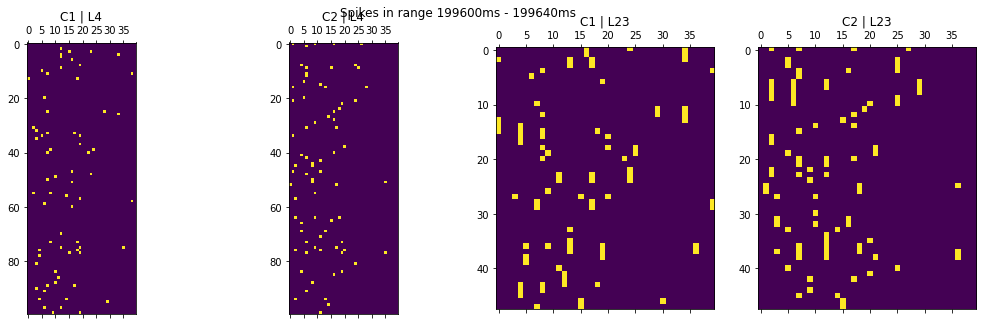

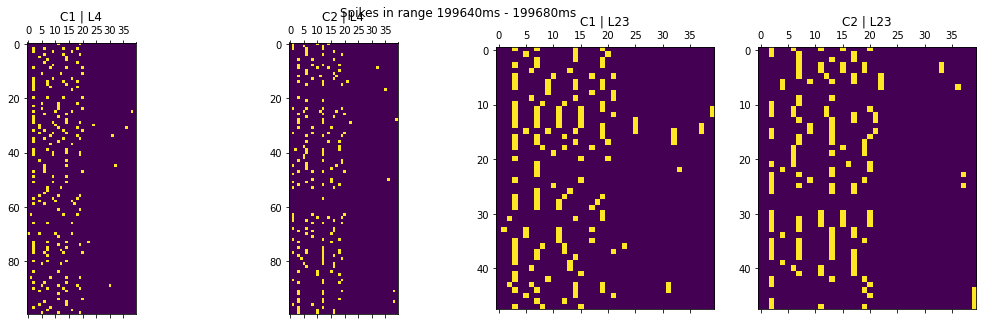

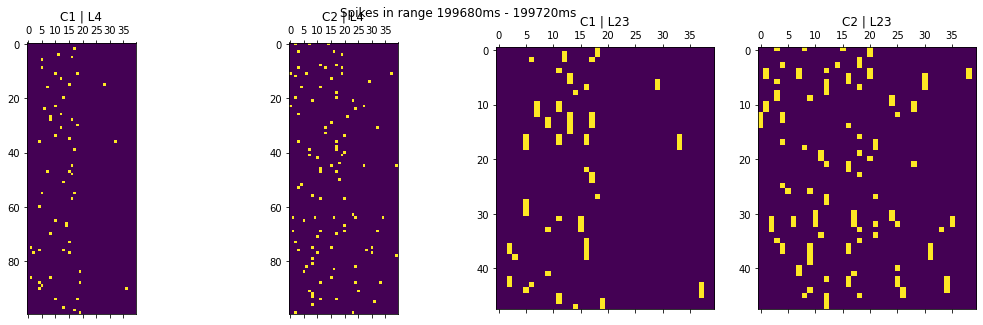

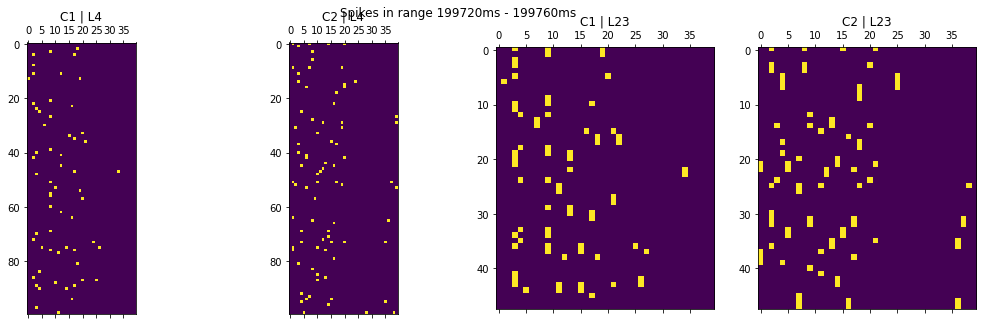

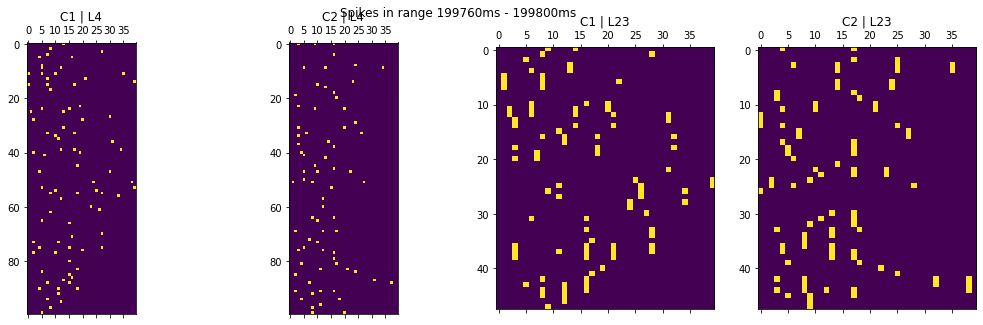

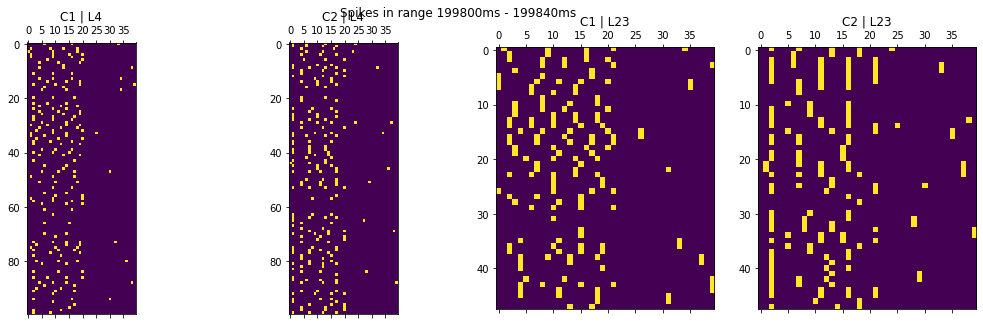

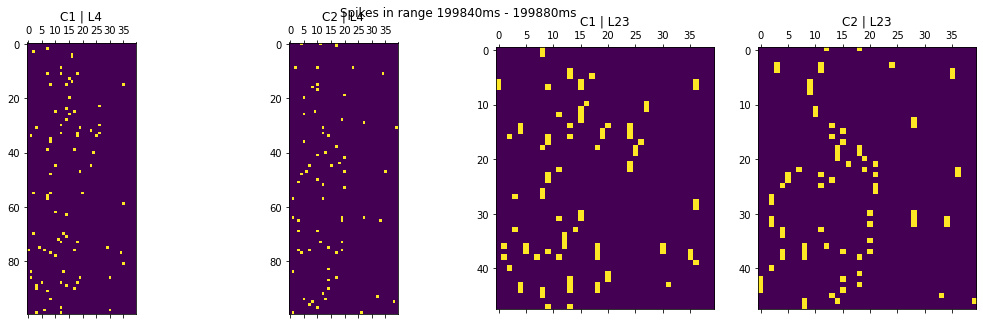

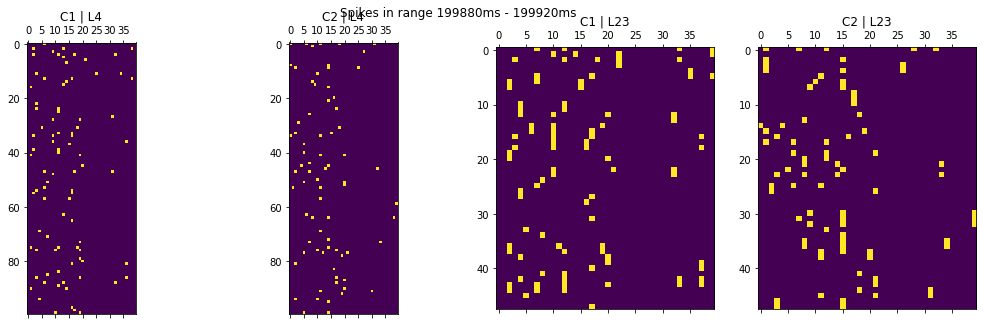

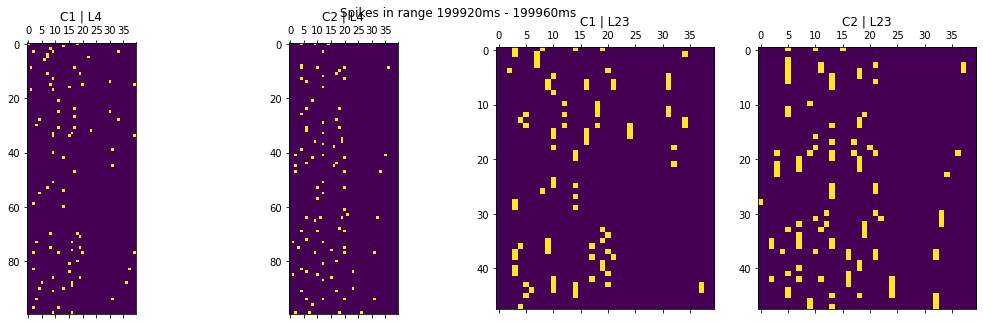

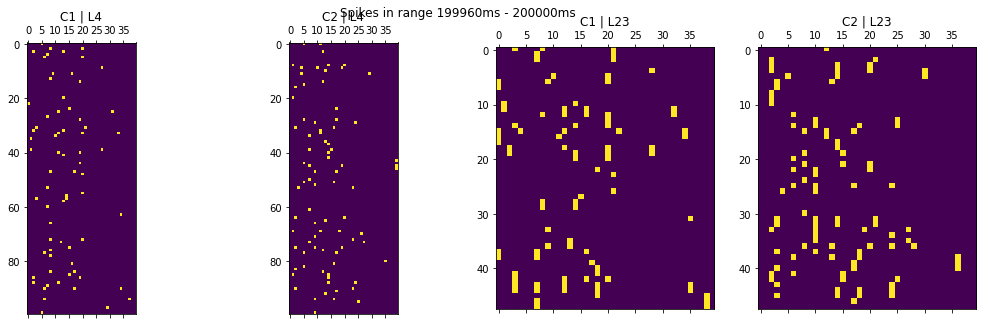

In [27]:
for i in visualization_range:
    show_spikes(i, ["C1 | L4", "C2 | L4", "C1 | L23", "C2 | L23"], fig_size=(18,5)) 

tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


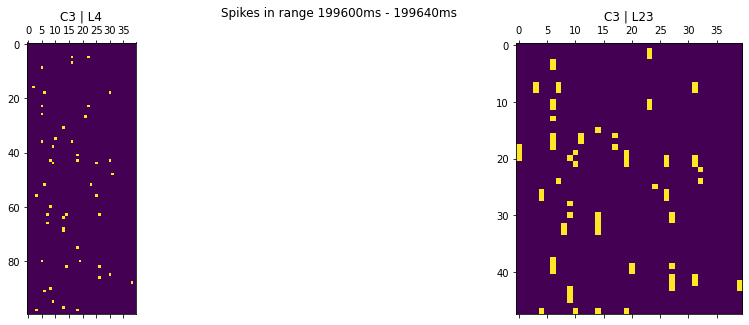

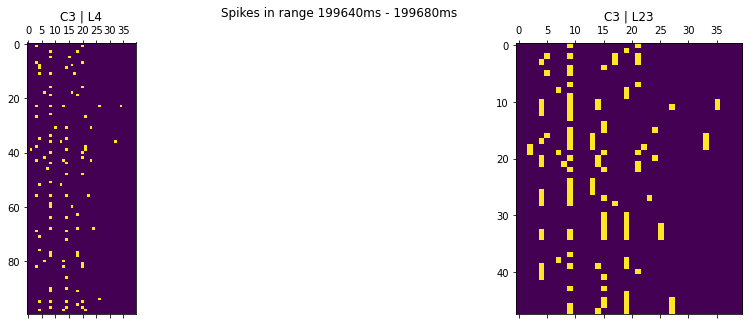

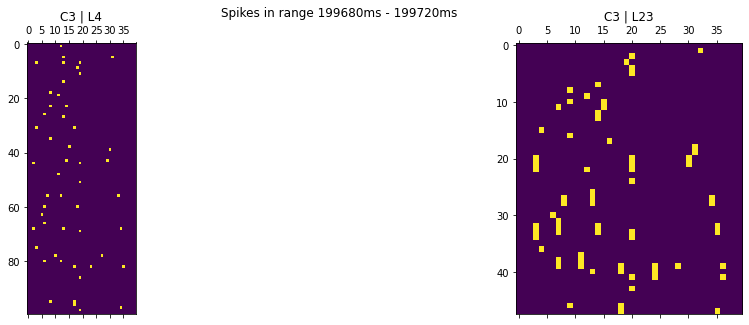

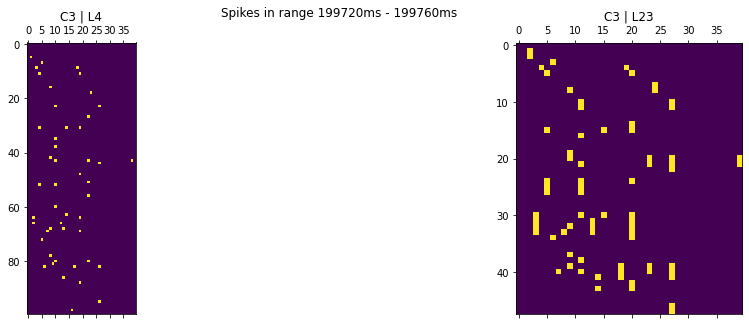

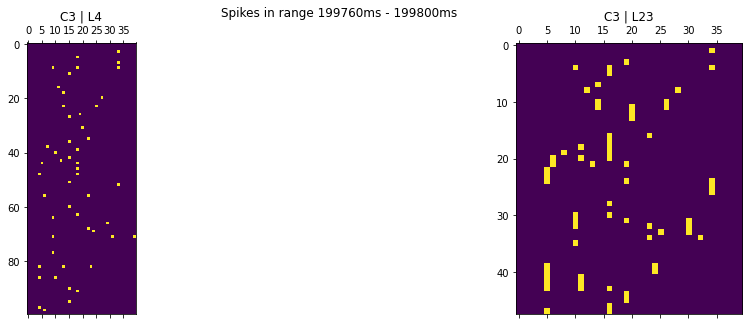

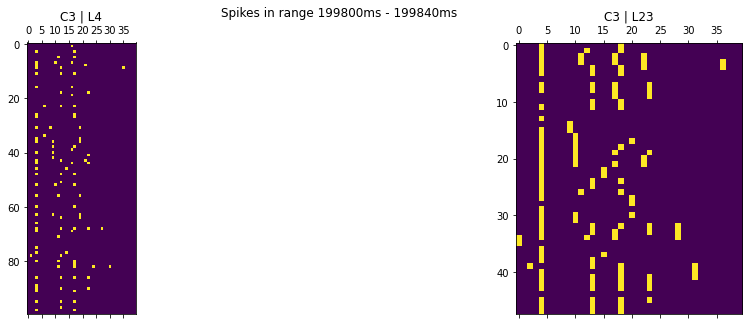

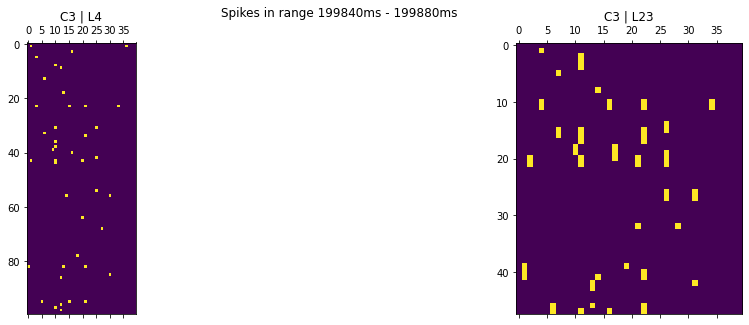

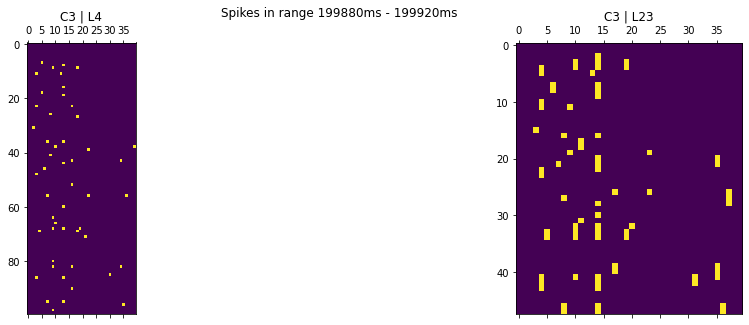

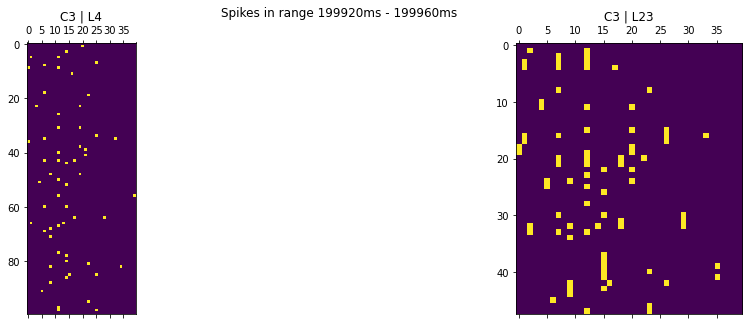

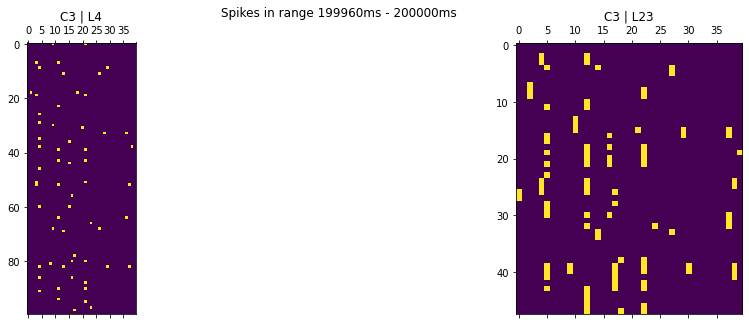

In [28]:
for i in visualization_range:
    show_spikes(i, ["C3 | L4", "C3 | L23"], fig_size=(18,5))
    print(session_class[i])

tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0.)
tensor(0.)
tensor(0.5769)
tensor(0.)
tensor(-0.4737)
tensor(0.)
tensor(0.6579)
tensor(0.)
tensor(0.)
tensor(0.)


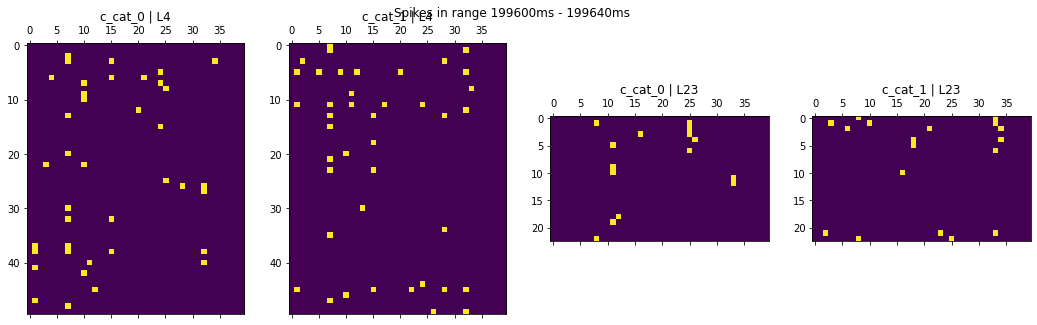

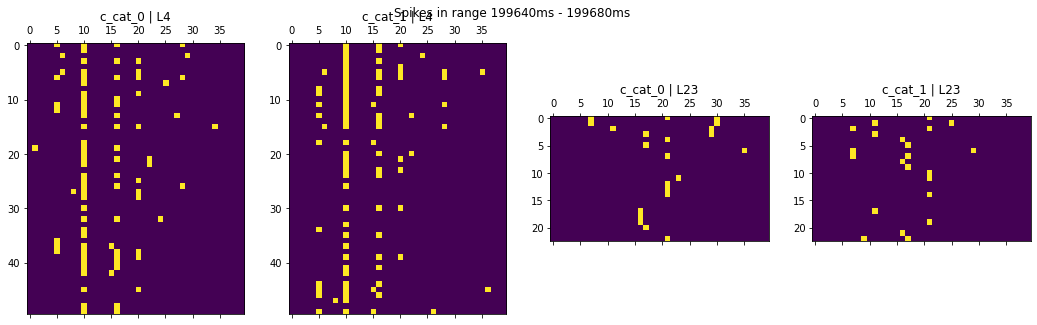

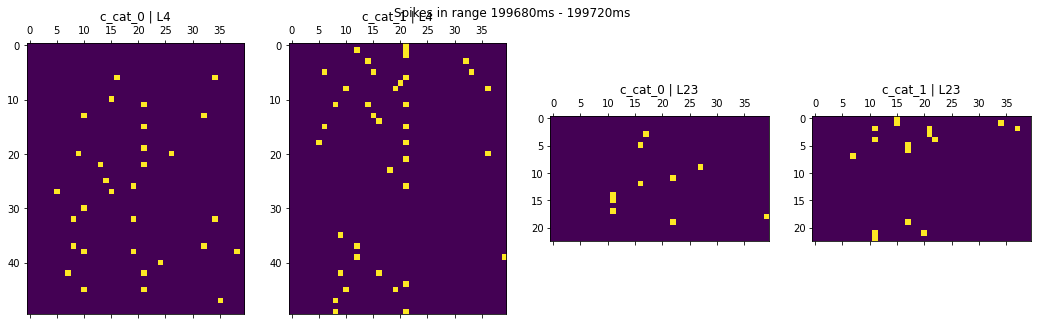

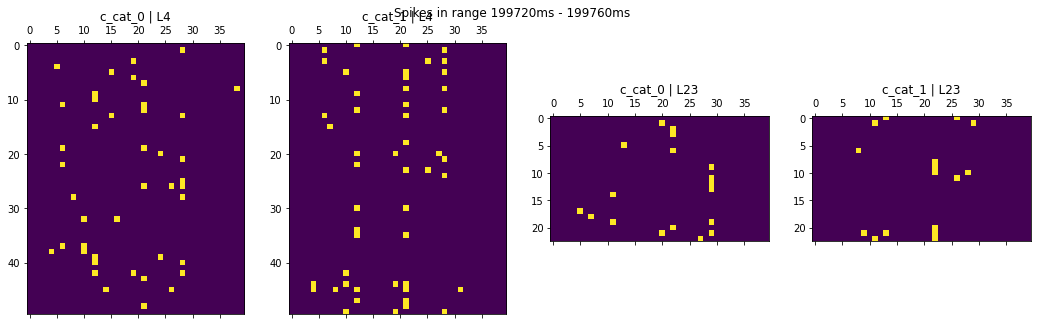

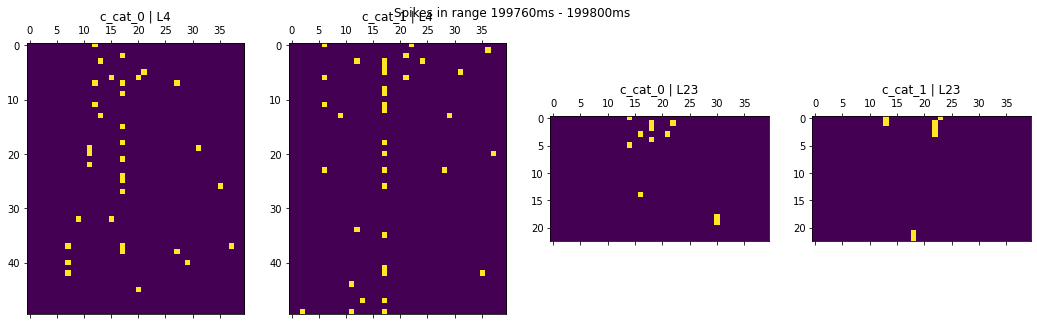

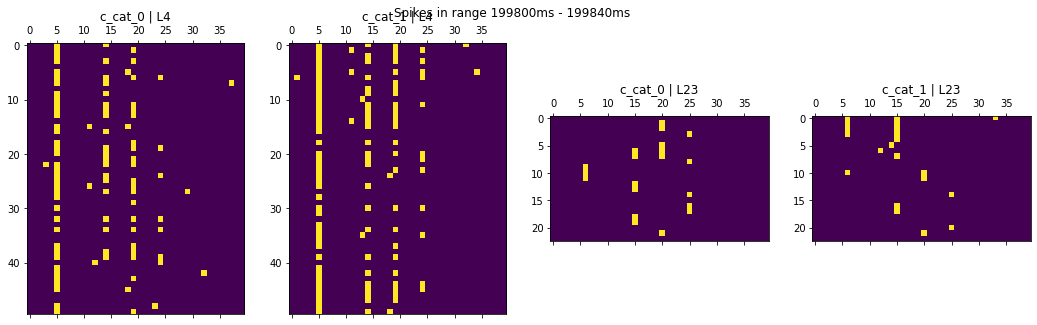

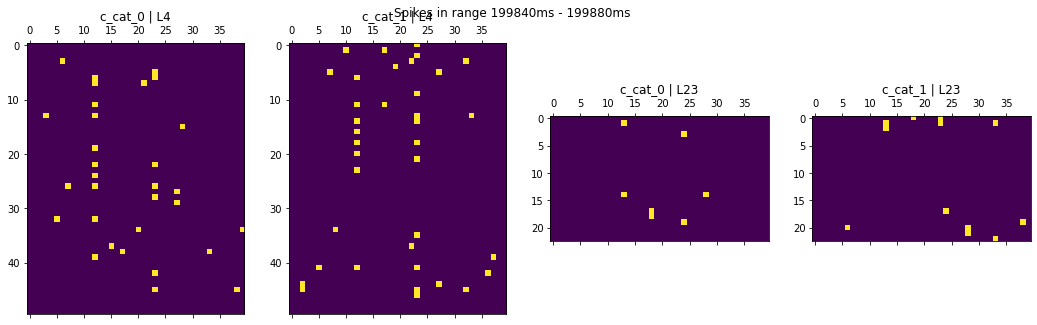

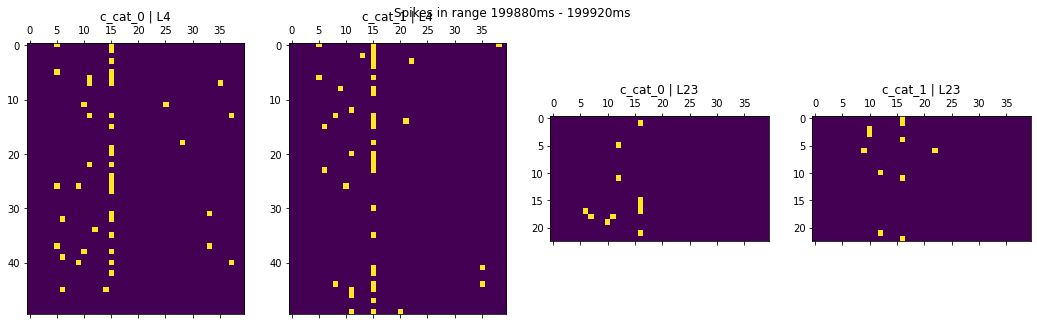

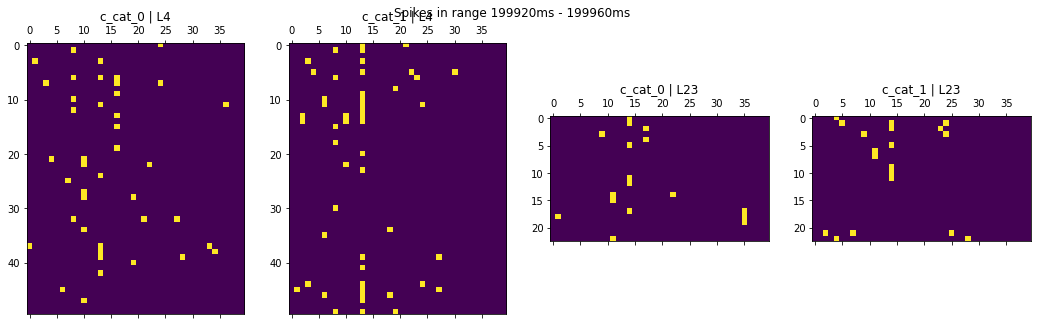

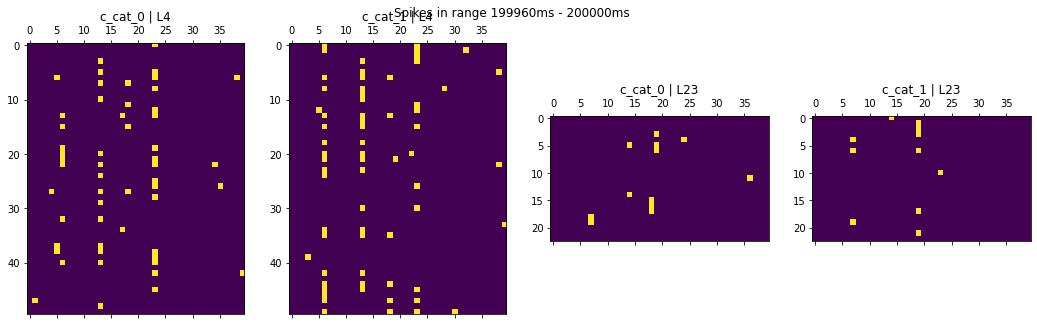

In [29]:
for i in visualization_range:
    show_spikes(i, ["c_cat_0 | L4", "c_cat_1 | L4", "c_cat_0 | L23", "c_cat_1 | L23"], fig_size=(18,5))
    print(session_class[i])
    
print("=============")
for i in visualization_range:
    print(rewards[i])

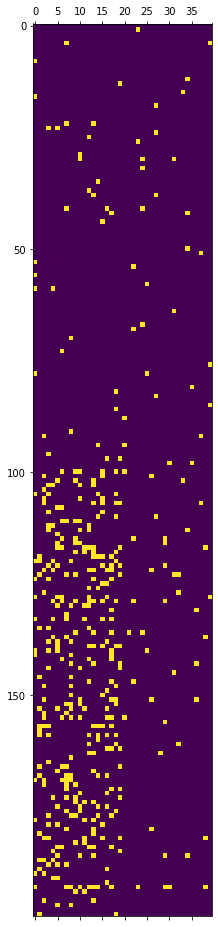

In [30]:
plt.matshow(spike_train_c1.T[:, :1 * each_session])

In [31]:
network.connections

{('c1_l4__pop',
  'c1_l23__pop'): [MaxPool1dConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c1_l23__pop',
  'c1_l23__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c1_l4__pop',
  'c1_l4__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('input_c1',
  'c1_l4__pop'): [RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )],
 ('c2_l4__pop',
  'c2_l23__pop'): [MaxPool1dConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c2_l23__pop',
  'c2_l23__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c2_l4__pop',
  'c2_l4__pop'): [RandomConnection(
    (s

In [32]:
for i in range(20):
    print(rewards[-i - 1])

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.6579)
tensor(0.)
tensor(-0.4737)
tensor(0.)
tensor(0.5769)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.5000)
tensor(0.)
tensor(-0.2143)
tensor(-0.7826)
tensor(0.)
tensor(0.)
